In [1]:
import numpy as np
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras

In [7]:
path = "F:\\MICCAI_BraTS_2019_Data_Training\\"

In [2]:
path1 = "F:\\MICCAI_BraTS_2019_Data_Training\\LGG\\"

In [3]:
files = glob.glob(path1 + "**\\*\\*flair.nii.gz", recursive = True)
len(files)

76

In [9]:
örnek = files[1]
img = io.imread(örnek, plugin = "simpleitk")

In [5]:
img.shape , img.dtype

((155, 240, 240), dtype('int16'))

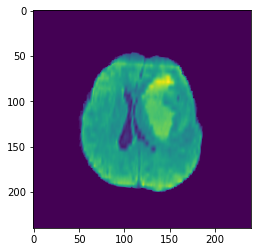

In [6]:
plt.imshow(img[90, : , :]) #axial kesit

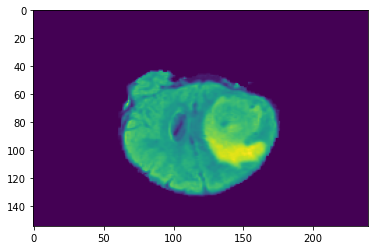

In [7]:
plt.imshow(img[:,90, :]) #coronal kesit

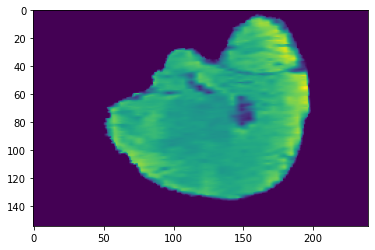

In [8]:
plt.imshow(img[:,:,90]) #sagital kesit

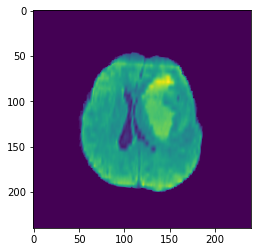

In [9]:
plt.imshow(img[90].reshape(240,240))

In [4]:
def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!
 
def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [17]:
train = train_array(path1, "**\\*flair.nii.gz")

In [20]:
seg_tam = seg_array(path1, "**\\*seg.nii.gz",1)
"""seg_nekroz = seg_array(path, "**\\*seg.nii.gz",2)
seg_ödemsiz = seg_array(path, "**\\*seg.nii.gz",3)
seg_genişleyen = seg_array(path, "**\\*seg.nii.gz",4)
seg_orj = seg_array(path, "**\\*seg.nii.gz",0)"""

'seg_nekroz = seg_array(path, "**\\*seg.nii.gz",2)\nseg_ödemsiz = seg_array(path, "**\\*seg.nii.gz",3)\nseg_genişleyen = seg_array(path, "**\\*seg.nii.gz",4)\nseg_orj = seg_array(path, "**\\*seg.nii.gz",0)'

In [21]:
seg_tam.shape , seg_tam.dtype, train.shape, train.dtype

((5320, 1, 240, 240), dtype('float32'), (5320, 1, 240, 240), dtype('float32'))

In [ ]:
x = 30
plt.figure(figsize = (15,10))
plt.subplot(3,4,1)
plt.imshow(seg_tam[x].reshape(240,240))


plt.subplot(3,4,2)
plt.imshow(seg_nekroz[x].reshape(240,240))


plt.subplot(3,4,3)
plt.imshow(seg_ödemsiz[x].reshape(240,240))


plt.subplot(3,4,4)
plt.imshow(seg_genişleyen[x].reshape(240,240))


plt.subplot(3,4,5)
plt.imshow(seg_orj[x].reshape(240,240))


plt.subplot(3,4,6)
plt.imshow(train[x].reshape(240,240))


In [6]:
#flair=train_array(path1 ,'**\\*flair.nii.gz')
#t2=train_array(path1 ,'**\\*t2.nii.gz')
seg=seg_array(path1,'**\\*seg.nii.gz',1)

In [ ]:
flair.shape, flair.dtype, t2.shape,t2.dtype,seg.shape,seg.dtype


In [7]:
x_train = np.concatenate((train_array(path1 ,'**\\*flair.nii.gz'),train_array(path1 ,'**\\*t2.nii.gz')),axis=1)


KeyboardInterrupt: 

In [8]:
x_train.dtype, x_train.shape,seg.shape,seg.dtype

(dtype('float32'), (5320, 2, 240, 240), (5320, 1, 240, 240), dtype('float32'))

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [ ]:
model = unet_model()
model.save_weights('C:\\Users\\user\\Desktop\\TRAINING\\u-net\\unet_model.h5')

In [ ]:
#list devices hatası için 
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


tfback._get_available_gpus = _get_available_gpus

In [ ]:
model.fit(x_train,seg,validation_split = 0.20, batch_size = 3, epochs = 1, shuffle = True ,verbose = 1)

In [ ]:
x    = 30
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4

örnek = np.expand_dims(x_train[x],axis=0)
pred = model.predict(örnek)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (Flair + T2)')
plt.imshow(x_train[x][0],cmap = renk[a])

plt.subplot(142)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Bilgisayarın tahmini (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])
